In [143]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

In [144]:
data1 = pd.read_csv('train/tweet_global_warming.csv',error_bad_lines=False,engine='python')
data2 = pd.read_csv('train/weather-evaluated-agg-DFE.csv',encoding='utf-8')
data3 = pd.read_csv('train/sentiment_nuclear_power.csv',error_bad_lines=False,engine='python')

In [145]:
data = pd.concat([data1['tweet'],data2['tweet_text'],data3['tweet_text']],axis=0)
data = shuffle(data)
data.index = range(len(data))

In [146]:
data.head()

0    CLIMATE CHANGE: Voice of Civil Society Loud an...
1    LAist| Protesters Take on Valero Over Initiati...
2    Thankfully, at least Rio Tinto's Preston Chiar...
3    Check this video out -- George Carlin on Globa...
4    Where Is Global Warming? by Rebecca Terrell, N...
dtype: object

## Preprocess

In [147]:
stopword = stopwords.words('english') 

In [148]:
def stemming(words):
    ps = nltk.stem.SnowballStemmer('english')
    new = []
    stem_words = [ps.stem(x) for x in words]
    return stem_words

In [149]:
def preprocess(sentence):
    sentence = contractions.fix(sentence)             # Replace contractions in string 
    sentence = re.sub('@\w+',"",str(sentence))        # remove mentions
    sentence = re.sub('#\w+',"",str(sentence))        # remove hashtags
    sentence = re.sub('http\S+',"",str(sentence))     # remove URLs
    sentence = re.sub('[^\w\s]'," ",str(sentence))    # remove punc
    sentence = re.sub('[^a-zA-Z]'," ",str(sentence))  # remove numbers
  
    sents = word_tokenize(sentence)                   # Tokenization
    sents = stemming(sents)
            
    new_sents = ""
    for i in range(len(sents)):                       # remove stopwords            
        if(sents[i].lower() not in stopword and sents[i]!='rt' and len(sents[i])>1):
            new_sents += sents[i].lower()+" "
    new_sents.strip()
    
    return new_sents

In [150]:
def preprocessing(xtrain):
    corpus = xtrain.apply(preprocess)
    return corpus

In [151]:
corpus = preprocessing(data)
corpus = corpus.drop_duplicates() 

## Feature Extraction

In [152]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [153]:
tfidf, vocab = featureextraction(corpus)

## Kmeans Clustering 

### Finding optimum number of clusters

In [154]:
def find_optimal_clusters(data, max_k):
    iters = range(1, max_k+1, 2)
    max_iterations = 300
    
    sse = []
    for k in iters:
        clustering_model = KMeans(n_clusters=k,max_iter=max_iterations,
                                  precompute_distances="auto",n_jobs=-1).fit(data)
        sse.append(clustering_model.inertia_ )
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 1 clusters
Fit 3 clusters
Fit 5 clusters
Fit 7 clusters
Fit 9 clusters
Fit 11 clusters
Fit 13 clusters
Fit 15 clusters
Fit 17 clusters
Fit 19 clusters


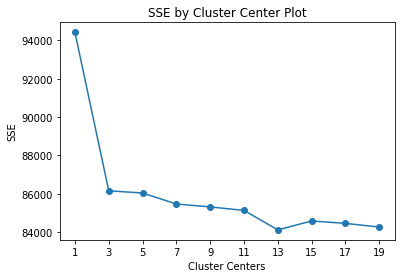

In [155]:
find_optimal_clusters(tfidf, 20)

In [156]:
np.shape(tfidf)

(6019, 34259)

In [166]:
clusters = KMeans(n_clusters=3, max_iter=300,precompute_distances="auto",
                  n_jobs=-1).fit_predict(tfidf)
clusters = np.array([x+1 for x in clusters])

### Plotting the clusters

In [167]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
#     max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
#     pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    pca = PCA(n_components=2).fit_transform(data.todense())
#     tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
#     idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
#     label_subset = labels[max_items]
    label_subset = labels
    label_subset = [cm.hsv(i/max_label) for i in label_subset]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

#     ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
#     ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

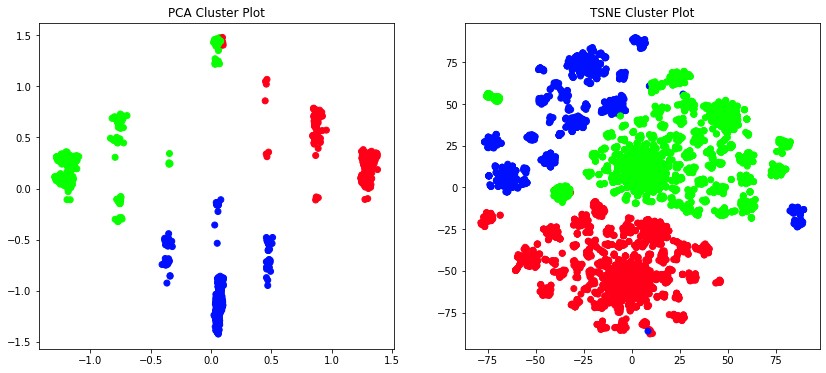

In [168]:
plot_tsne_pca(tfidf, clusters)

In [160]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [161]:
get_top_keywords(tfidf, clusters, vocab, 10)


Cluster 0
hot,sunni,day,nuclear power,power,chang,storm,nuclear,weather,link

Cluster 1
scientist,say,new,chang,snow,climat,link,global warm,warm,global

Cluster 2
energi,chang link,world,peopl,news,new,link,climat chang,chang,climat


In [169]:
df = pd.DataFrame({'label': clusters, 'tweets': range(0,len(corpus))})

In [170]:
print(df.sort_values('label').head())

      label  tweets
0         1       0
3122      1    3122
3125      1    3125
3127      1    3127
3128      1    3128


In [171]:
df['label'].unique()

array([1, 3, 2])

In [172]:
df['label'].value_counts(ascending = False)

1    2529
3    2186
2    1304
Name: label, dtype: int64

### check out the group with the least posts

In [175]:
index = list(df[df['label']==1]['tweets'])

In [176]:
corpus.iloc[index]

0       climat chang voic civil societi loud clear coc...
1       laist protest take valero initi would chang ca...
6       assum site legit explain connect call global w...
7       author nikola kozloff rain amazon south americ...
8       acid ocean worsen expert warn climat chang msn...
                              ...                        
7263            usa week climat chang polici updat april 
7269                              polit climat chang via 
7277    extrem weather across globe due strong el nino...
7278    tackl climat chang must achiev bold strategi y...
7279    climat chang fraud global warm balanc quot say...
Length: 2529, dtype: object

In [178]:
index = list(df[df['label']==3]['tweets'])

In [179]:
corpus.iloc[index]

2       thank least rio tinto preston chiaro posit sta...
3                   check video georg carlin global warm 
4             global warm rebecca terrel newamerican com 
5       scientif communiti scame global green gov warm...
10      great unravel profession global warm alarmist ...
                              ...                        
7268     plz king coal big ag tri outlaw global warm rep 
7270    obama doe minut earth day video fail mention g...
7272    preliminari analysi suggest natur gas could co...
7273    scam anoth warmist rescu arctic cold global wa...
7276    go sinc yet global warm continu depreci earth ...
Length: 2186, dtype: object